In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.stats import pearsonr, spearmanr, kruskal
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder


In [3]:
# Set main directory
os.chdir("/Users/giandomenico/Documents/SAPIENZA/AR/MiC/Ferrara")
# set plotting settings
sns.set_theme(context='paper', style="whitegrid", palette="husl", font='arial', font_scale=1.2)

plt.rcParams.update({
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11
    })


In [4]:
# Load datasets
filepath = 'PS_vs_Geo/buildings_bbcc_Ferrara_def3857_intersect_sampled.gpkg'
data = gpd.read_file(filepath)



data.columns

Index(['codice', 'nome', 'tipo_tutel', 'tipo_propr', 'categoria', 'eta',
       'eta_attest', 'stato', 'lon', 'lat', 'x', 'y', 'etichetta',
       'Interventi', 'Data inizi', 'Data fine', 'Ind_danno', 'note', 'Descr',
       'ASC_VEL_median', 'ASC_VEL_stdev', 'ASC_VEL_min', 'ASC_VEL_max',
       'ASC_CUM_median', 'ASC_CUM_stdev', 'ASC_CUM_min', 'ASC_CUM_max',
       'DESC_VEL_median', 'DESC_VEL_stdev', 'DESC_VEL_min', 'DESC_VEL_max',
       'DESC_CUM_median', 'DESC_CUM_stdev', 'DESC_CUM_min', 'DESC_CUM_max',
       'UD_VEL_median', 'UD_VEL_stdev', 'UD_VEL_min', 'UD_VEL_max',
       'geometry'],
      dtype='object')

In [5]:
# select important columns only
cols_to_keep = ['codice', 'Descr', 'ASC_VEL_median', 'ASC_VEL_stdev', 'ASC_VEL_min', 'ASC_VEL_max',
       'ASC_CUM_median', 'ASC_CUM_stdev', 'ASC_CUM_min', 'ASC_CUM_max',
       'DESC_VEL_median', 'DESC_VEL_stdev', 'DESC_VEL_min', 'DESC_VEL_max',
       'DESC_CUM_median', 'DESC_CUM_stdev', 'DESC_CUM_min', 'DESC_CUM_max',
       'UD_VEL_median', 'UD_VEL_stdev', 'UD_VEL_min', 'UD_VEL_max',
       'geometry']

data_clean = data[cols_to_keep]

# drop nan
data_clean = data_clean.dropna()

data_clean.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 664 entries, 0 to 698
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   codice           664 non-null    object  
 1   Descr            664 non-null    object  
 2   ASC_VEL_median   664 non-null    float64 
 3   ASC_VEL_stdev    664 non-null    float64 
 4   ASC_VEL_min      664 non-null    float64 
 5   ASC_VEL_max      664 non-null    float64 
 6   ASC_CUM_median   664 non-null    float64 
 7   ASC_CUM_stdev    664 non-null    float64 
 8   ASC_CUM_min      664 non-null    float64 
 9   ASC_CUM_max      664 non-null    float64 
 10  DESC_VEL_median  664 non-null    float64 
 11  DESC_VEL_stdev   664 non-null    float64 
 12  DESC_VEL_min     664 non-null    float64 
 13  DESC_VEL_max     664 non-null    float64 
 14  DESC_CUM_median  664 non-null    float64 
 15  DESC_CUM_stdev   664 non-null    float64 
 16  DESC_CUM_min     664 non-null    flo

In [6]:
data_clean.Descr.value_counts()

argille e limi di deposito interalveo              255
Limi con sabbie di  argine e venaglio di rotta     244
Sabbie di riempimento di canale fluviale           115
Sabbie limose di riempimento di canale fluviale     39
Sabbie e limi di riempimento di canale fluviale      7
Lmi con sabbie di argine e venaglio di rotta         2
Limi con sabbie di argine venaglio da rotta          1
Argille e limi di deposito interalvei                1
Name: Descr, dtype: int64

### Map lithology values

In [7]:
# Define the mapping dictionary
mapping = {
    'argille e limi di deposito interalveo': 'Floodplain deposits',
    'Argille e limi di deposito interalvei': 'Floodplain deposits',
    'Limi con sabbie di  argine e venaglio di rotta': 'Levee and crevasse splay deposits',
    'Lmi con sabbie di argine e venaglio di rotta': 'Levee and crevasse splay deposits',
    'Limi con sabbie di argine venaglio da rotta': 'Levee and crevasse splay deposits',
    'Sabbie di riempimento di canale fluviale': 'Channel fill deposits',
    'Sabbie limose di riempimento di canale fluviale': 'Channel fill deposits',
    'Sabbie e limi di riempimento di canale fluviale': 'Channel fill deposits'
}

In [8]:
# Apply the mapping to the column
data_clean['Lithology'] = data_clean['Descr'].map(mapping)

# Print value counts of the new column to verify the result
print(data_clean['Lithology'].value_counts())

Floodplain deposits                  256
Levee and crevasse splay deposits    247
Channel fill deposits                161
Name: Lithology, dtype: int64


In [9]:
# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the 'Lithology' column to get encoded labels
data_clean['Lithology_enc'] = encoder.fit_transform(data_clean['Lithology'])

# Print the modified DataFrame
print(data_clean.Lithology_enc.value_counts())

1    256
2    247
0    161
Name: Lithology_enc, dtype: int64


In [10]:
data_clean.to_file('PS_vs_Geo/buildings_bbcc_Ferrara_def3857_intersect_sampled_filtered.gpkg')

# Hypotesis Testing

In [11]:
# Set ASC, DESC, UD variables
asc_vel = 'ASC_VEL_median'
desc_vel = 'DESC_VEL_median'
ud_vel = 'UD_VEL_median'
asc_cum = 'ASC_CUM_median'
desc_cum = 'DESC_CUM_median'

# Calculate the mean, minimum, and maximum values for each group
asc_velocity_stats = data_clean.groupby('Lithology')[asc_vel].agg(['median', 'min', 'max', 'std']).reset_index()
desc_velocity_stats = data_clean.groupby('Lithology')[desc_vel].agg(['median', 'min', 'max', 'std']).reset_index()
ud_disp_stats = data_clean.groupby('Lithology')[ud_vel].agg(['median', 'min', 'max', 'std']).reset_index()


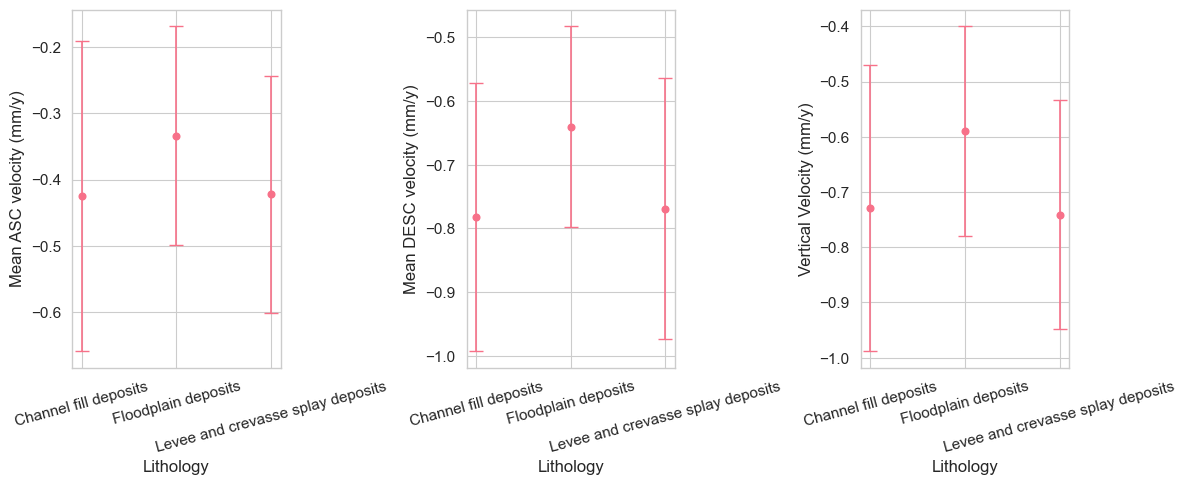

In [12]:
# Plot the scatter points with error bars
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.errorbar(asc_velocity_stats['Lithology'], asc_velocity_stats['median'], yerr=asc_velocity_stats['std'], fmt='o', capsize=5)
ax2.errorbar(desc_velocity_stats['Lithology'], desc_velocity_stats['median'], yerr=desc_velocity_stats['std'], fmt='o', capsize=5)
ax3.errorbar(ud_disp_stats['Lithology'], ud_disp_stats['median'], yerr=ud_disp_stats['std'], fmt='o', capsize=5)

ax1.set_xlabel('Lithology')
ax1.set_ylabel('Mean ASC velocity (mm/y)')
ax2.set_xlabel('Lithology')
ax2.set_ylabel('Mean DESC velocity (mm/y)')
ax3.set_xlabel('Lithology')
ax3.set_ylabel('Vertical Velocity (mm/y)')

for tick in ax1.get_xticklabels():
    tick.set_rotation(15)
for tick in ax2.get_xticklabels():
    tick.set_rotation(15)
for tick in ax3.get_xticklabels():
    tick.set_rotation(15)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.show()

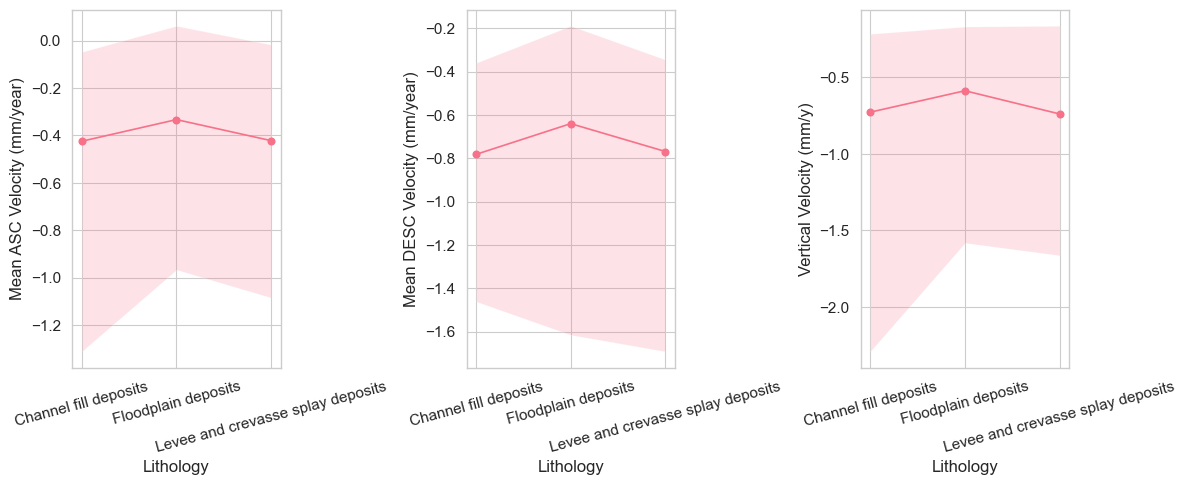

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.plot(asc_velocity_stats['Lithology'], asc_velocity_stats['median'], 'o-')
ax1.fill_between(asc_velocity_stats['Lithology'], asc_velocity_stats['min'], asc_velocity_stats['max'], alpha=0.2)

ax2.plot(desc_velocity_stats['Lithology'], desc_velocity_stats['median'], 'o-')
ax2.fill_between(desc_velocity_stats['Lithology'], desc_velocity_stats['min'], desc_velocity_stats['max'], alpha=0.2)

ax3.plot(ud_disp_stats['Lithology'], ud_disp_stats['median'], 'o-')
ax3.fill_between(ud_disp_stats['Lithology'], ud_disp_stats['min'], ud_disp_stats['max'], alpha=0.2)

ax1.set_xlabel('Lithology')
ax1.set_ylabel('Mean ASC Velocity (mm/year)')
ax1.set_xticks(np.arange(len(asc_velocity_stats['Lithology'])))
ax1.set_xticklabels(asc_velocity_stats['Lithology'], rotation=15)

ax2.set_xlabel('Lithology')
ax2.set_ylabel('Mean DESC Velocity (mm/year)')
ax2.set_xticks(ud_disp_stats['Lithology'])
ax2.set_xticklabels(ud_disp_stats['Lithology'], rotation=15)

ax3.set_xlabel('Lithology')
ax3.set_ylabel('Vertical Velocity (mm/y)')
ax3.set_xticks(ud_disp_stats['Lithology'])
ax3.set_xticklabels(ud_disp_stats['Lithology'], rotation=15)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

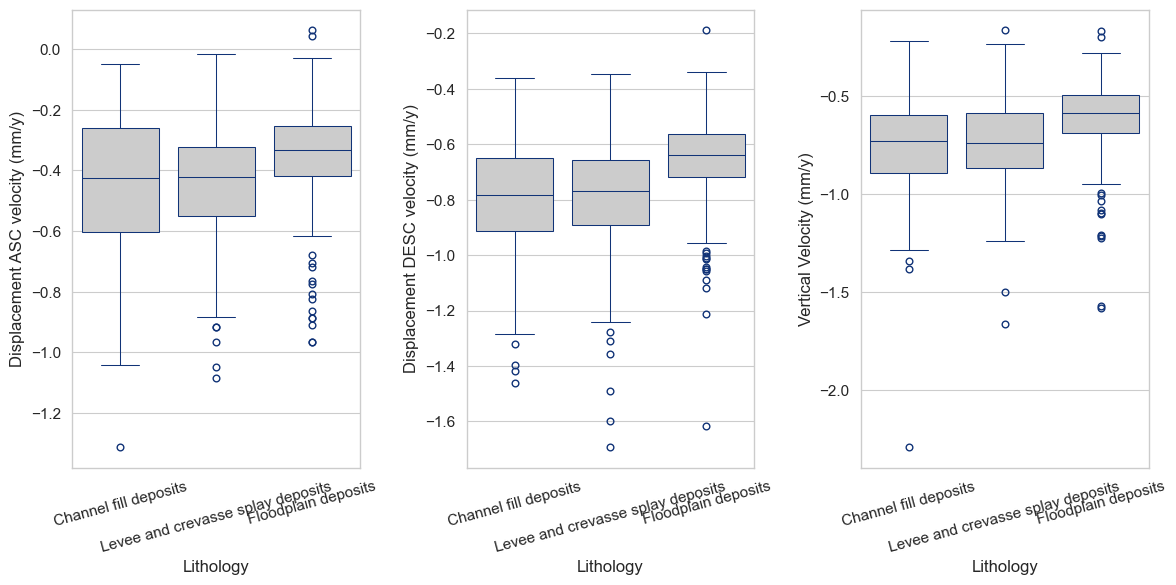

In [14]:
X = 'Lithology'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

ax1 = sns.boxplot(data=data_clean, x=X, y=asc_vel, color=".8", linecolor="#137", linewidth=.75, ax=ax1)
ax2 = sns.boxplot(data=data_clean, x=X, y=desc_vel, color=".8", linecolor="#137", linewidth=.75, ax=ax2)
ax3 = sns.boxplot(data=data_clean, x=X, y=ud_vel, color=".8", linecolor="#137", linewidth=.75, ax=ax3)

ax1.set_xlabel("Lithology")
ax1.set_ylabel("Displacement ASC velocity (mm/y)")
for tick in ax1.get_xticklabels():
    tick.set_rotation(15)

ax2.set_xlabel("Lithology")
ax2.set_ylabel("Displacement DESC velocity (mm/y)")
for tick in ax2.get_xticklabels():
    tick.set_rotation(15)

ax3.set_xlabel("Lithology")
ax3.set_ylabel("Vertical Velocity (mm/y)")
for tick in ax3.get_xticklabels():
    tick.set_rotation(15)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

# Display the plot
plt.show()

PearsonRResult(statistic=0.01749921355760283, pvalue=0.6526325374801805)
Kruskal-Wallis test (ASC_VEL_median): Stat=43.87831155632179, P-value=2.9644607728520575e-10
Tukey test (ASC_VEL_median):
                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
        group1                      group2              meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------
Channel fill deposits               Floodplain deposits    0.091    0.0  0.0463  0.1356   True
Channel fill deposits Levee and crevasse splay deposits  -0.0034 0.9823 -0.0484  0.0415  False
  Floodplain deposits Levee and crevasse splay deposits  -0.0944    0.0  -0.134 -0.0548   True
----------------------------------------------------------------------------------------------


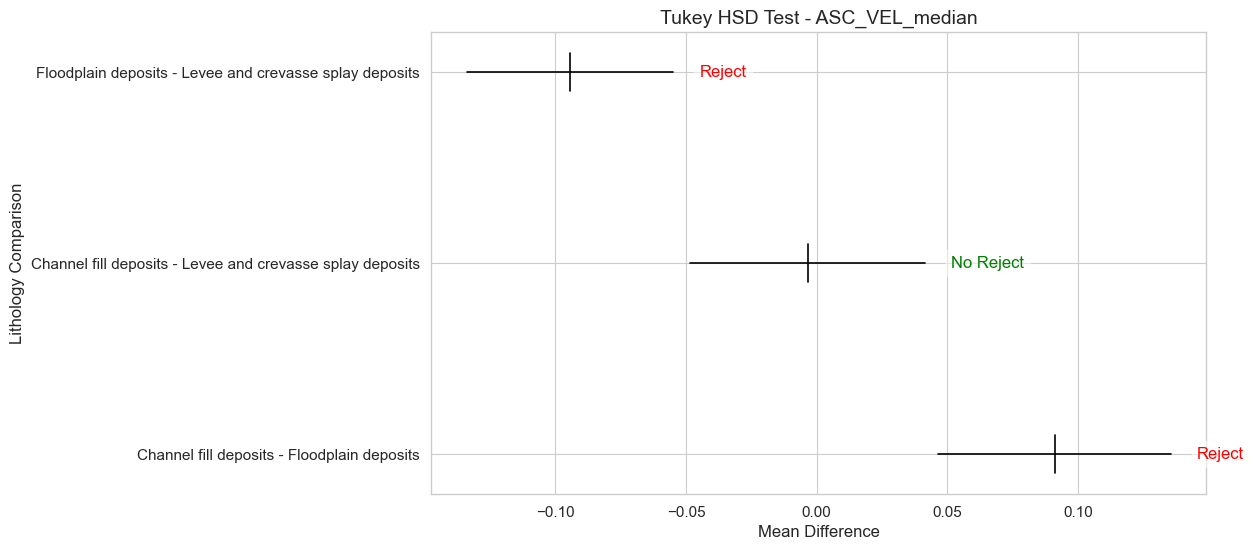

Kruskal-Wallis test (DESC_VEL_median): Stat=80.22816232617421, P-value=3.790320237114629e-18
Tukey test (DESC_VEL_median):
                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
        group1                      group2              meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------
Channel fill deposits               Floodplain deposits   0.1384    0.0  0.0937  0.1832   True
Channel fill deposits Levee and crevasse splay deposits   0.0149 0.7156 -0.0301    0.06  False
  Floodplain deposits Levee and crevasse splay deposits  -0.1235    0.0 -0.1632 -0.0838   True
----------------------------------------------------------------------------------------------


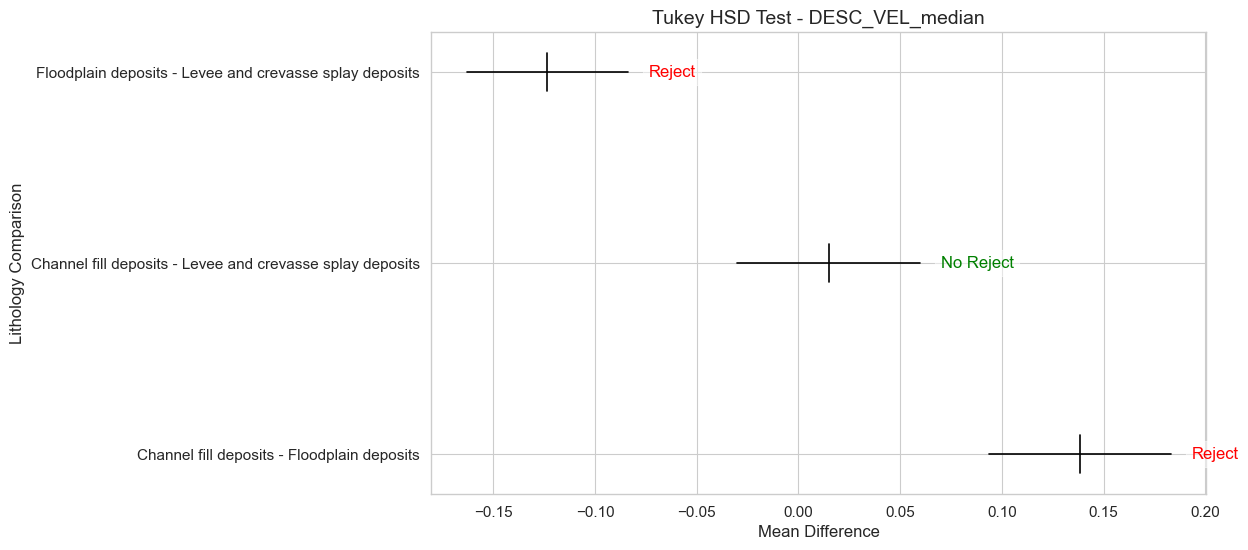

Kruskal-Wallis test (UD_VEL_median): Stat=76.98331173290669, P-value=1.9199338156797712e-17
Tukey test (UD_VEL_median):
                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
        group1                      group2              meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------------------------------
Channel fill deposits               Floodplain deposits   0.1578    0.0   0.107 0.2087   True
Channel fill deposits Levee and crevasse splay deposits   0.0337 0.2688 -0.0174 0.0849  False
  Floodplain deposits Levee and crevasse splay deposits  -0.1241    0.0 -0.1692 -0.079   True
---------------------------------------------------------------------------------------------


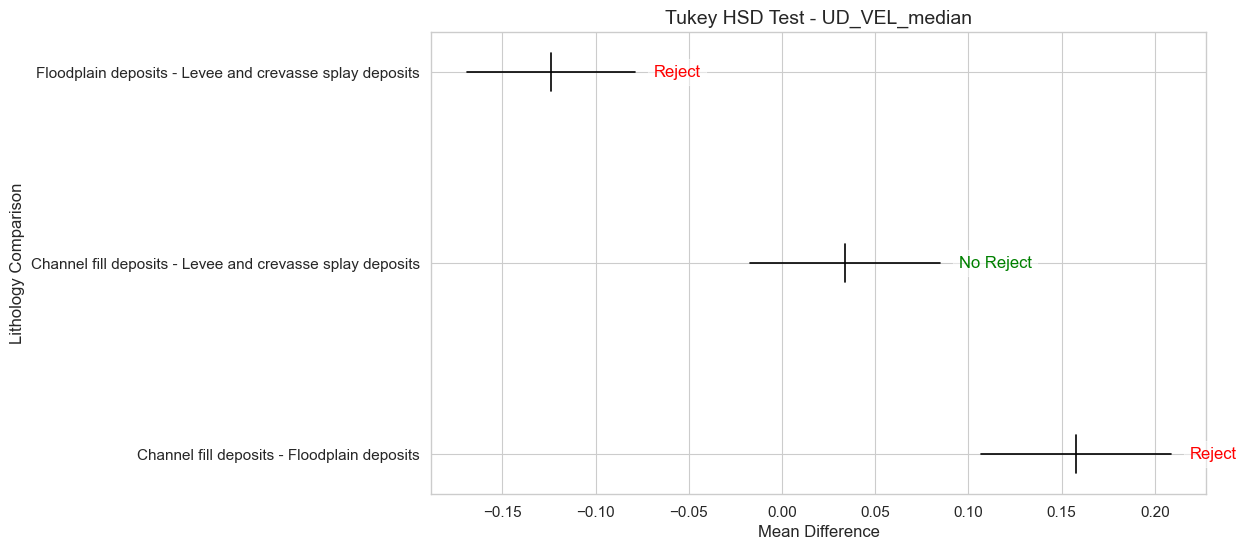

In [26]:
# Calculate the correlation between displacement and other geological attributes
correlation = pearsonr(data_clean['Lithology_enc'], data_clean[ud_vel])
print(correlation)

ordinal = [asc_vel, desc_vel, ud_vel] #  asc_cum, desc_cum
nominal = 'Lithology'

# ANOVA/Kruskal-Wallis test for deformation rates across different geological types
for v in ordinal:
    groups = [data_clean[v][data_clean[nominal] == gt] for gt in data_clean[nominal].unique()]
    stat, p_value = kruskal(*groups)
    print(f'Kruskal-Wallis test ({v}): Stat={stat}, P-value={p_value}')
    # Tukey test
    if p_value < 0.05:
        tukey = pairwise_tukeyhsd(data_clean[v], data_clean[nominal])
        tukey_summary = tukey.summary()
        print(f'Tukey test ({v}):\n{tukey_summary}')

        # Plot Tukey test results
        fig, ax = plt.subplots(figsize=(10, 6))
        for i in range(len(tukey._results_table.data) - 1):
            group1, group2, meandiff, p_adj, lower, upper, reject = tukey._results_table.data[i + 1]
            y_pos = i + 1  # y-axis position
            
            ax.plot([lower, upper], [y_pos, y_pos], color='black')
            ax.plot([meandiff, meandiff], [y_pos - 0.1, y_pos + 0.1], color='black')
            
            # annotate reject result
            ax.text(upper + 0.01, y_pos, 'Reject' if reject else 'No Reject', 
                    color='red' if reject else 'green', 
                    ha='left', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        
        ax.set_yticks(range(1, len(tukey._results_table.data)))
        ax.set_yticklabels([f'{group1} - {group2}' for group1, group2 in zip(
            [row[0] for row in tukey._results_table.data[1:]], 
            [row[1] for row in tukey._results_table.data[1:]]
            )])
        ax.set_title(f'Tukey HSD Test - {v}')
        ax.set_xlabel('Mean Difference')
        ax.set_ylabel('Lithology Comparison')
        
        plt.show()

#### Key Concepts of the Results Obtained

In the Tukey HSD test results:

- **Red Annotations ("Reject")**: Indicate that the null hypothesis for that pair of groups has been rejected. This means there is a **statistically significant difference** between the means of those two groups.

- **Green Annotations ("No Reject")**: Indicate that the null hypothesis has **not been rejected** for that pair of groups. This means there is **no statistically significant difference** between the means of those two groups.

#### Summary of the Results:

1. **For ASC_VEL_median**:
   - Channel fill deposits vs. Floodplain deposits**: Significant difference (Reject - Red).
   - Channel fill deposits vs. Levee and crevasse splay deposits**: No significant difference (No Reject - Green).
   - Floodplain deposits vs. Levee and crevasse splay deposits**: Significant difference (Reject - Red).

2. **For DESC_VEL_median**:
   - Channel fill deposits vs. Floodplain deposits**: Significant difference (Reject - Red).
   - Channel fill deposits vs. Levee and crevasse splay deposits**: No significant difference (No Reject - Green).
   - Floodplain deposits vs. Levee and crevasse splay deposits**: Significant difference (Reject - Red).

3. **For UD_VEL_median**:
   - Channel fill deposits vs. Floodplain deposits**: Significant difference (Reject - Red).
   - Channel fill deposits vs. Levee and crevasse splay deposits**: No significant difference (No Reject - Green).
   - Floodplain deposits vs. Levee and crevasse splay deposits**: Significant difference (Reject - Red).

#### Key Takeaways:

- The **red annotations** show which pairs of groups have meaningful differences in their median velocity values, indicating areas where the underlying geological factors might be influencing the behavior of the terrain.
- The **green annotations** suggest that, for those pairs, the observed differences are not statistically significant, meaning they could be due to random variation or other factors not captured in the test.

These insights help to identify which types of terrain exhibit different behaviors, potentially guiding further investigation or decision-making related to land use, construction, or risk assessment.

## Cluster analysis

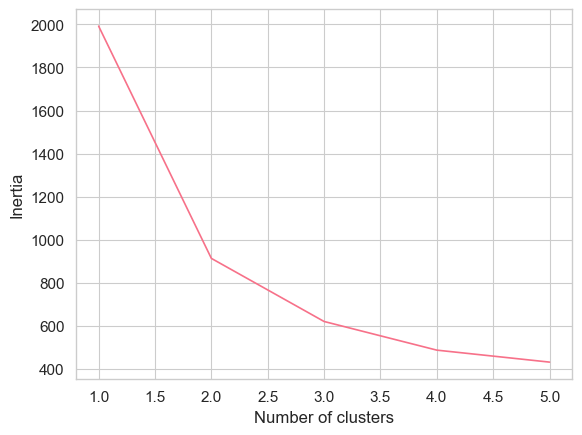

In [51]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select the relevant features
# features = data_clean[[asc_vel, desc_vel, ud_vel, asc_cum, desc_cum]]
features = data_clean[[asc_vel, desc_vel, ud_vel]]


# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 6), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [53]:
# Based on the elbow plot, choose the optimal number of clusters (e.g., 2)
n_clusters = 2

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the original dataframe
data_clean['Cluster'] = clusters

# Print the clusters
print(data_clean.groupby('Cluster').agg({asc_vel: 'mean', desc_vel:'mean', ud_vel: 'mean',
                                         asc_cum:'mean', desc_cum:'mean', 
                                         'Lithology': 'nunique'}))

         ASC_VEL_median  DESC_VEL_median  UD_VEL_median  ASC_CUM_median  \
Cluster                                                                   
0             -0.598375        -0.940342      -0.925441       -7.060300   
1             -0.304420        -0.633602      -0.572048       -3.484238   

         DESC_CUM_median  Lithology  
Cluster                              
0              -12.71284          3  
1               -9.10135          3  


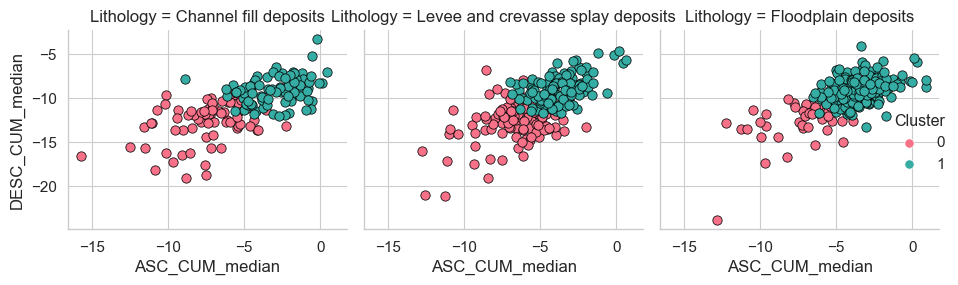

In [54]:
palette = sns.color_palette("husl", n_colors=len(data_clean['Cluster'].unique()))

# Create scatterplot with columns based on 'Litologia' and colored by 'cluster'
g = sns.FacetGrid(data_clean, col="Lithology", hue="Cluster", col_wrap=3, palette=palette, height=3, aspect=1)
g.map(sns.scatterplot, asc_cum, desc_cum, marker="o", s=45)
g.add_legend(title="Cluster")

# Set marker edge color for all scatter points
for ax in g.axes.flat:
    for collection in ax.collections:
        if isinstance(collection, matplotlib.collections.PathCollection):
            collection.set_edgecolor("black")

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.show()

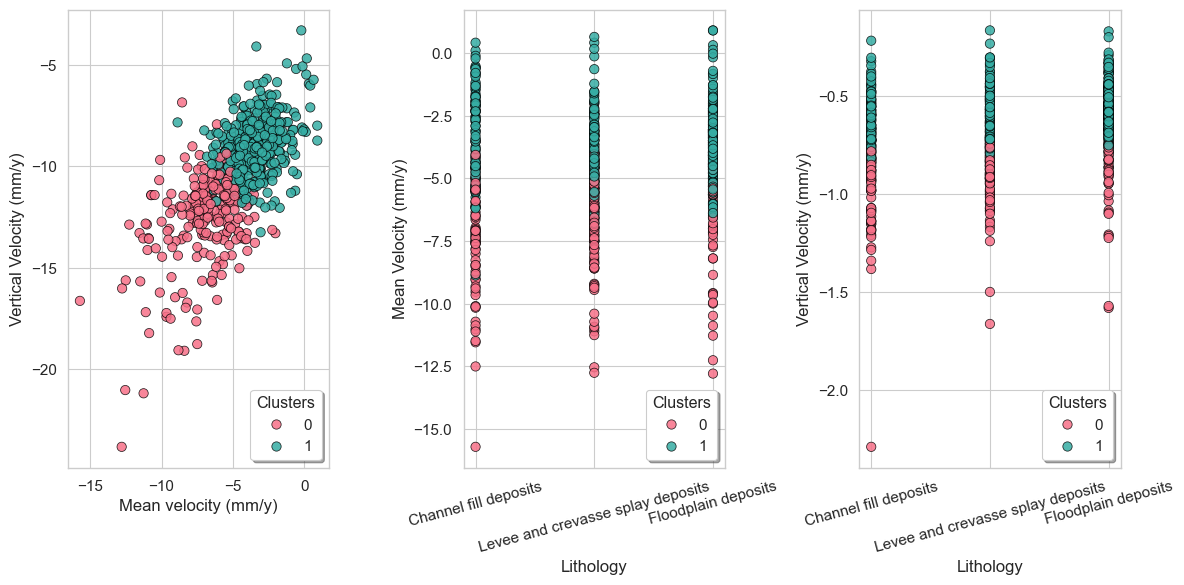

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))

# Plot VEL_ASC vs. UD_CUM colored by cluster
scatter1 = sns.scatterplot(x=asc_cum, y=desc_cum, data=data_clean, hue='Cluster', ax=ax1,
                           s=45, alpha=0.85, edgecolor='k', palette=palette)

# ax1.set_title('VEL_ASC vs. UD_CUM (Colored by Cluster)')
ax1.legend(bbox_to_anchor=(1, 0), loc='lower right', frameon=True, shadow=True, title='Clusters')  # Move the legend outside the plot
ax1.set_xlabel("Mean velocity (mm/y)")
ax1.set_ylabel("Vertical Velocity (mm/y)")

# Plot VEL_ASC vs. COD_gt colored by cluster
scatter2 = sns.scatterplot(x='Lithology', y=asc_cum, data=data_clean, hue='Cluster', ax=ax2,
                           s=45, alpha=0.85, edgecolor='k', palette=palette)

ax2.legend(bbox_to_anchor=(1, 0), loc='lower right', frameon=True, shadow=True, title='Clusters')  # Move the legend outside the plot
ax2.set_ylabel("Mean Velocity (mm/y)")
for tick in ax2.get_xticklabels():
    tick.set_rotation(15)

scatter3 = sns.scatterplot(x='Lithology', y=ud_vel, data=data_clean, hue='Cluster', ax=ax3,
                           s=45, alpha=0.85, edgecolor='k', palette=palette)

# ax3.set_title('UD_CUM vs. Litologia (Colored by Cluster)')
ax3.legend(bbox_to_anchor=(1, 0), loc='lower right', frameon=True, shadow=True, title='Clusters')  # Move the legend outside the plot
ax3.set_ylabel("Vertical Velocity (mm/y)")
for tick in ax3.get_xticklabels():
    tick.set_rotation(15)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

# Show the plot
plt.show()

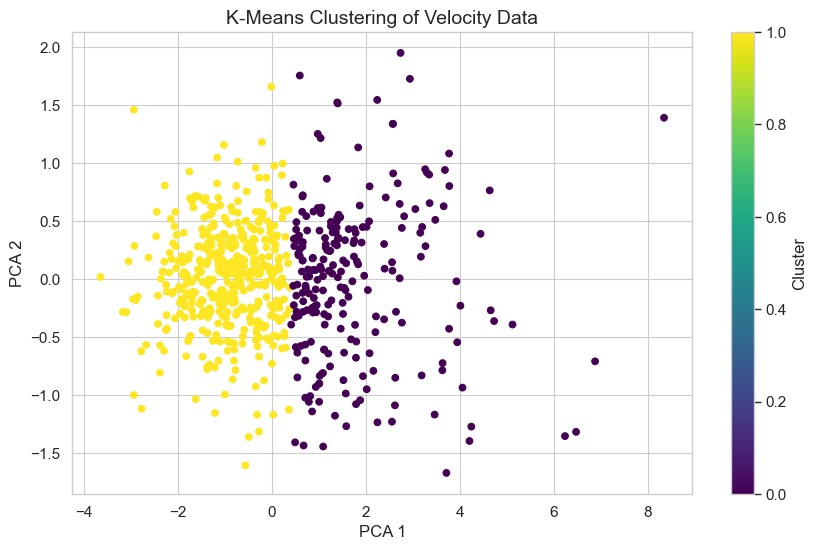

In [56]:
# Perform PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-Means Clustering of Velocity Data')
plt.colorbar(label='Cluster')
plt.show()